In [1]:
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
#from DrawingUtils import plot_extreme_points,graph_plane,PlotPolytope
import random as rnd
import time

# Creating an object-orientated computational graph

In [2]:
class Variable:
    def __init__(self, variable, constraints):
        self.cvx_var = variable
        self.constraints = constraints
    
    def add(self, variable):
        cvx_var = cvxpy.Variable()
        constraint = [cvx_var == self.cvx_var + variable.cvx_var]
        constraints = []
        constraints.extend(self.constraints)
        constraints.extend(variable.constraints)
        constraints.extend(constraint)
        
        return Variable(cvx_var,constraints)
    
    def multiply(self, variable):
        cvx_var = cvxpy.Variable()
        b1 = self.getBounds()
        b2 = variable.getBounds()
        mccormick_constraints = self.McCormick(cvx_var,self.cvx_var,variable.cvx_var,
                                     b1, b2)
        constraints = []
        constraints.extend(self.constraints)
        constraints.extend(variable.constraints)
        constraints.extend(mccormick_constraints)
        
        return Variable(cvx_var,constraints)
    
    def getBounds(self):
        return self.bounds(self.cvx_var, self.constraints)
    
    @staticmethod
    def bounds(x,constraints,Npast=0):
        objective_max = cvxpy.Maximize(x)
        problem_maximum = cvxpy.Problem(objective_max,constraints[-Npast:])
        value_max = problem_maximum.solve(solver=cvxpy.GUROBI)

        objective_min = cvxpy.Minimize(x)
        problem_minimum = cvxpy.Problem(objective_min,constraints[-Npast:])
        value_min = problem_minimum.solve(solver=cvxpy.GUROBI)

        return (value_min,value_max)
    
    @staticmethod
    def McCormick(w,x,y,x_bounds,y_bounds):
#         print(x_bounds,y_bounds)
        xL,xU = x_bounds
        yL,yU = y_bounds

        c = []
        c.append(w >= xL*y + x*yL - xL*yL)
        c.append(w >= xU*y + x*yU - xU*yU)
        c.append(w <= xU*y + x*yL - xU*yL)
        c.append(w <= x*yU + xL*y - xL*yU)
        return c
    
class Constant(Variable):
    # Do constant.multiply(variable) and constant.add(variable) - not other way
    def __init__(self, value):
        cvx_var = cvxpy.Variable()
        constraints = [cvx_var == value]
        super().__init__(cvx_var, constraints)
        self.value = value
    
    def multiply(self, variable):
        cvx_var = cvxpy.Variable()
        constraints = [cvx_var == self.value*variable.cvx_var]
        constraints.extend(variable.constraints)
        return Variable(cvx_var, constraints)
    
    def add(self, variable):
        cvx_var = cvxpy.Variable()
        constraints = [cvx_var == self.value + variable.cvx_var]
        constraints.extend(variable.constraints)
        return Variable(cvx_var, constraints)

## Testing with Lotka-Volterra model

In [3]:
# horizon and forward Euler time step
T = 5
del_t = 1

# box constraints for initial state
x0 = 1
y0 = 1
x_dev = 0.01
y_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0

# constants for dynamics
constants = {"a":1, "b":1, "lambda":2, 
             "c":1, "d":1, "mu":2, 
             "T":T, "del_t":del_t,
             "x0":x0, "y0":y0}

x_var, y_var = cvxpy.Variable(), cvxpy.Variable()
constraints = [x_var <= x_up_b, x_var >= x_lw_b,
                            y_var <= y_up_b, y_var >= y_lw_b]

x, y = Variable(x_var,constraints), Variable(y_var, constraints)
a, b, lamb, c, d, mu, del_t = Constant(1), Constant(-1), Constant(-2), Constant(1), Constant(-1), Constant(-2), Constant(del_t)

# Lotka Volterra
(Implementation by Anand, based of "Van Der Pol" implementation by Vicenc)

Lotka Volterra (discretized) dynamics:

$x_{t+1} = (a - by_t - \lambda x_t)x_t \Delta_t + x_t $         
$y_{t+1} = (cx_t - d - \mu y_t)y_t \Delta_t + y_t $

$a,b,c,d,\lambda,\mu > 0 $

0
Academic license - for non-commercial use only


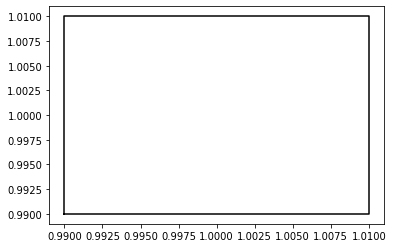

1


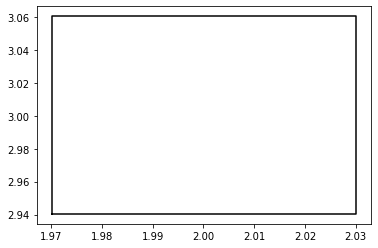

2


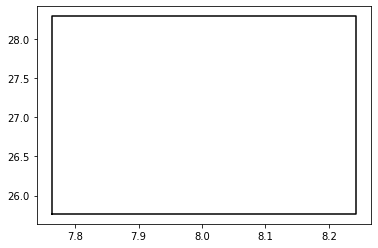

3


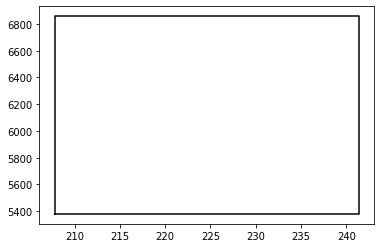

KeyboardInterrupt: 

In [4]:
# Note: made constants that are subtracted into negatives so they can be added
fig = plt.figure(1)
boxes = []
for t in range(5):
    print(t)
    x_bounds = x.getBounds()
    y_bounds = y.getBounds()
    
    ######### lil plot
    xL,xU = x_bounds
    yL,yU = y_bounds
    if t>=0: 
        plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
    fig.canvas.draw()   # draw
    plt.pause(1.01)
    ########
    
#     w = del_t.multiply(x)
#     s = a.add((b.multiply(y)).add(lamb.multiply(x)))
#     x = x.add(s.multiply(w))
    
#     t = del_t.multiply(y)
#     r = d.add((mu.multiply(y)).add(c.multiply(x)))
#     y = y.add(r.multiply(t))

    x = x.multiply(y).add(x)
    y = x.multiply(y).add(y)
    constraints = []
    constraints.extend(x.constraints)
    constraints.extend(y.constraints)
    x.constraints, y.constraints = constraints, constraints
    
#     x, y = y.add(x), x.add(y)
    
#     tt = time.time() - tt
#     times.append(tt)
#     print("Time for ",t,"-th loop: ",tt)

# plt.figure(2)
# plt.plot(times,'r*')